#### Supplement Figure 2

##### Package imports, figure settings, color definitions
<img src="color_pal.png" width="500">

/Users/mlanghinrichs/Documents/Studium/MSc/09_hiwi_hoefer/01_project/memo_py/memo_py/selection.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


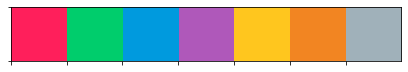

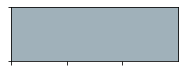

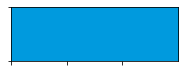

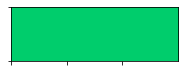

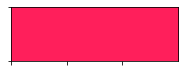

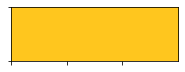

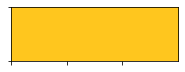

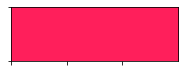

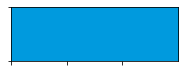

In [1]:
%matplotlib inline
%run settings_load.py

##### load data and field-well annotation

In [2]:
data = pickle.load(open('waiting_times_files/count_data_cd44_manual_counting_18_01_14_filtered_sigma022.pickle', 'rb'))
print(data.data_counts.shape)

# see cd44_data_explore, we have the following fields and wells
fields_well_list = [(0, 1), (0, 2), (6, 1), (6, 2), (12, 1), (12, 2), (12, 3), (18, 1), (18, 2), (18, 3), (24, 2), (24, 3), (30, 1), (30, 2), (36, 2), (36, 3), (42, 2), (48, 1), (48, 2), (48, 3), (54, 1), (54, 2), (54, 3), (60, 3), (66, 1), (66, 2), (66, 3), (72, 1), (78, 2), (78, 3), (84, 1), (84, 2), (84, 3), (90, 1), (90, 3), (96, 1), (96, 2), (102, 1), (102, 2), (102, 3), (108, 1), (108, 2), (114, 1), (114, 3)]
print(len(fields_well_list))

(44, 2, 28)
44


##### check well data with raw count data

In [3]:
# load plain count data manual_counting_18_01_14
data_counts_raw = np.zeros((44, 2, 28))
df_count_data = pd.read_csv('../../cd44_data/manual_counting_18_01_14.csv', ';', header=(0))
# display(df_count_data)
# display(df_count_data[df_count_data.param=="total"])

for i, (field, well) in enumerate(fields_well_list):
    cd44pos = df_count_data[(df_count_data.field==field) & (df_count_data.well==well) 
                        & ((df_count_data.param=='plusplus') | (df_count_data.param=='plusminus'))].iloc[:, 0:28].sum()
    cd44neg = df_count_data[(df_count_data.field==field) & (df_count_data.well==well) 
                        & ((df_count_data.param=='minusplus') | (df_count_data.param=='minusminus'))].iloc[:, 0:28].sum()
    data_counts_raw[i, 0, :] = cd44pos
    data_counts_raw[i, 1, :] = cd44neg

In [4]:
np.all(data_counts_raw == data.data_counts)

True

##### extract bead numbers from raw count data file

In [5]:
bead_numbers = list()
for field, well in fields_well_list:
    bead_num = df_count_data[(df_count_data.param=='total') &(df_count_data.field==field) & (df_count_data.well==well)]['beads']
#     print(field, well, int(bead_num))
    bead_numbers.append(int(bead_num))

In [6]:
max(bead_numbers)

14

##### correlate final time point with bead numbers

In [7]:
data.data_counts[:, 0, -1]

array([3., 7., 5., 0., 2., 1., 0., 6., 1., 5., 2., 3., 0., 6., 3., 4., 6.,
       4., 0., 1., 3., 0., 6., 4., 0., 3., 5., 2., 6., 7., 1., 1., 5., 5.,
       0., 7., 9., 5., 4., 0., 6., 0., 8., 5.])

(0.10368754626528842, 0.502989066977258)
SpearmanrResult(correlation=0.0954418357937434, pvalue=0.537714142206917)


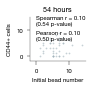

In [41]:
time_point = 54 # 18, 36, 54
cell_numbers = data.data_counts[:, 0, int(time_point/2)]
plt.rcParams.update({'figure.figsize': (1.0, 0.8)})
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.title(f'{time_point} hours')
plt.scatter(bead_numbers, cell_numbers, color=grey, alpha=0.6, s=3.0, lw=0.0) # , s=1.0)
plt.xlabel('Initial bead number')
plt.ylabel(f'CD44+ cells')

plt.xlim((-2, 15))
plt.ylim((-2, 15))
# plt.legend()

pearson = stats.pearsonr(bead_numbers, cell_numbers)
spearman = stats.spearmanr(bead_numbers, cell_numbers)
plt.text(0, 6, f'Pearson r = {pearson[0]:.2f} \n({pearson[1]:.2f} p-value)')
plt.text(0, 12, f'Spearman r = {spearman[0]:.2f} \n({spearman[1]:.2f} p-value)')

plt.savefig(f'paper_figures/data_beads_vs_active_{time_point}.pdf', bbox_inches='tight')

print(stats.pearsonr(bead_numbers, cell_numbers))
print(stats.spearmanr(bead_numbers, cell_numbers))

##### bead effects on waiting times

In [7]:
data.events_find_all()

8
8
28
Average bead number +/- std (sem) (no event) = 5.38 +/- 2.0 (0.71)
Average bead number +/- std (sem) (slow event) = 5.5 +/- 2.35 (0.83)
Average bead number +/- std (sem) (fast event) = 5.96 +/- 2.9 (0.55)


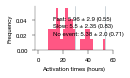

In [28]:
events = data.event_all_first_cell_type_conversion

hist_bins = np.linspace(0, 54, num=28, endpoint=True)
hist_tau = [tau - 1e-06 for (event_bool, tau) in events if event_bool]

beads_no_events = list()
beads_slow_events = list()
beads_fast_events = list()
for event_i, (event_bool, tau) in enumerate(events):
    if event_bool:
        if tau > 30:
            beads_slow_events.append(bead_numbers[event_i])
        else:
            beads_fast_events.append(bead_numbers[event_i])
    else:
        beads_no_events.append(bead_numbers[event_i])

print(len(beads_no_events))
print(len(beads_slow_events))
print(len(beads_fast_events))

print(fr'Average bead number +/- std (sem) (no event) = {round(np.mean(beads_no_events),2)} +/- {round(np.std(beads_no_events),2)} ({round(stats.sem(beads_no_events, ddof=0),2)})')
print(fr'Average bead number +/- std (sem) (slow event) = {round(np.mean(beads_slow_events),2)} +/- {round(np.std(beads_slow_events),2)} ({round(stats.sem(beads_slow_events, ddof=0),2)})')
print(fr'Average bead number +/- std (sem) (fast event) = {round(np.mean(beads_fast_events),2)} +/- {round(np.std(beads_fast_events),2)} ({round(stats.sem(beads_fast_events, ddof=0),2)})')

plt.figure(figsize=(1.4, 0.8))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xlabel('Activation times (hours)')
plt.ylabel('Frequency')
plt.hist(hist_tau,
                bins=hist_bins,
                color=cwact,
                density=True,
                alpha=0.75,
                histtype='stepfilled', # step, stepfilled
                linewidth=2.0)

plt.axvline(x=30.0, linewidth=0.5, color=grey)
plt.axvline(x=54.0, linewidth=0.5, color=grey)

plt.text(12, 0.02, f'No event: {round(np.mean(beads_no_events),2)} ± {round(np.std(beads_no_events),2)} ({round(stats.sem(beads_no_events, ddof=0),2)})')
plt.text(12, 0.03, f'Slow: {round(np.mean(beads_slow_events),2)} ± {round(np.std(beads_slow_events),2)} ({round(stats.sem(beads_slow_events, ddof=0),2)})')
plt.text(12, 0.04, f'Fast: {round(np.mean(beads_fast_events),2)} ± {round(np.std(beads_fast_events),2)} ({round(stats.sem(beads_fast_events, ddof=0),2)})')

plt.xlim(None, 60)
# plt.legend()
plt.savefig('paper_figures/data_waiting_time_event_activation.pdf', bbox_inches='tight')

In [11]:
# events = data.event_all_first_cell_count_increase

# hist_bins = np.linspace(0, 54, num=28, endpoint=True)
# hist_tau = [tau - 1e-06 for (event_bool, tau) in events if event_bool]

# beads_no_events = list()
# beads_slow_events = list()
# beads_fast_events = list()
# for event_i, (event_bool, tau) in enumerate(events):
#     if event_bool:
#         if tau > 40:
#             beads_slow_events.append(bead_numbers[event_i])
#         else:
#             beads_fast_events.append(bead_numbers[event_i])
#     else:
#         beads_no_events.append(bead_numbers[event_i])

# print(len(beads_no_events))
# print(len(beads_slow_events))
# print(len(beads_fast_events))

# print(fr'Average bead number +/- std (sem) (no event) = {round(np.mean(beads_no_events),2)} +/- {round(np.std(beads_no_events),2)} ({round(stats.sem(beads_no_events, ddof=0),2)})')
# print(fr'Average bead number +/- std (sem) (slow event) = {round(np.mean(beads_slow_events),2)} +/- {round(np.std(beads_slow_events),2)} ({round(stats.sem(beads_slow_events, ddof=0),2)})')
# print(fr'Average bead number +/- std (sem) (fast event) = {round(np.mean(beads_fast_events),2)} +/- {round(np.std(beads_fast_events),2)} ({round(stats.sem(beads_fast_events, ddof=0),2)})')

# plt.figure(figsize=(1.2, 0.8))
# ax = plt.gca()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(True)
# ax.spines['left'].set_visible(True)
# plt.xlabel('Division 1 times (hours)')
# plt.ylabel('Frequency')
# plt.hist(hist_tau,
#                 bins=hist_bins,
#                 color=cwdiv,
#                 density=True,
#                 histtype='stepfilled', # step, stepfilled
#                 linewidth=2.0)

# plt.axvline(x=40.0, linewidth=0.5, color=grey)
# plt.axvline(x=54.0, linewidth=0.5, color=grey)

# plt.xlim(None, 60)
# # plt.legend()
# plt.savefig('paper_figures/data_waiting_time_event_division1.pdf', bbox_inches='tight')

14
16
14
Average bead number +/- std (sem) (no event) = 5.79 +/- 2.34 (0.62)
Average bead number +/- std (sem) (slow event) = 6.25 +/- 3.21 (0.8)
Average bead number +/- std (sem) (fast event) = 5.21 +/- 2.14 (0.57)


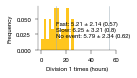

In [25]:
events = data.event_all_first_cell_count_increase_after_cell_type_conversion

hist_bins = np.linspace(0, 54, num=28, endpoint=True)
hist_tau = [tau - 1e-06 for (event_bool, tau) in events if event_bool]

beads_no_events = list()
beads_slow_events = list()
beads_fast_events = list()
for event_i, (event_bool, tau) in enumerate(events):
    if event_bool:
        if tau > 12:
            beads_slow_events.append(bead_numbers[event_i])
        else:
            beads_fast_events.append(bead_numbers[event_i])
    else:
        beads_no_events.append(bead_numbers[event_i])

print(len(beads_no_events))
print(len(beads_slow_events))
print(len(beads_fast_events))

print(fr'Average bead number +/- std (sem) (no event) = {round(np.mean(beads_no_events),2)} +/- {round(np.std(beads_no_events),2)} ({round(stats.sem(beads_no_events, ddof=0),2)})')
print(fr'Average bead number +/- std (sem) (slow event) = {round(np.mean(beads_slow_events),2)} +/- {round(np.std(beads_slow_events),2)} ({round(stats.sem(beads_slow_events, ddof=0),2)})')
print(fr'Average bead number +/- std (sem) (fast event) = {round(np.mean(beads_fast_events),2)} +/- {round(np.std(beads_fast_events),2)} ({round(stats.sem(beads_fast_events, ddof=0),2)})')

plt.figure(figsize=(1.4, 0.8))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xlabel('Division 1 times (hours)')
plt.ylabel('Frequency')
plt.hist(hist_tau,
                bins=hist_bins,
                color=cwdiv,
                density=True,
                histtype='stepfilled', # step, stepfilled
                linewidth=2.0)

plt.axvline(x=12.0, linewidth=0.5, color=grey)
plt.axvline(x=54.0, linewidth=0.5, color=grey)

plt.text(12, 0.02, f'No event: {round(np.mean(beads_no_events),2)} ± {round(np.std(beads_no_events),2)} ({round(stats.sem(beads_no_events, ddof=0),2)})')
plt.text(12, 0.03, f'Slow: {round(np.mean(beads_slow_events),2)} ± {round(np.std(beads_slow_events),2)} ({round(stats.sem(beads_slow_events, ddof=0),2)})')
plt.text(12, 0.04, f'Fast: {round(np.mean(beads_fast_events),2)} ± {round(np.std(beads_fast_events),2)} ({round(stats.sem(beads_fast_events, ddof=0),2)})')

plt.xlim(None, 60)
# plt.legend()
plt.savefig('paper_figures/data_waiting_time_event_division1.pdf', bbox_inches='tight')

17
15
12
Average bead number +/- std (sem) (no event) = 5.59 ± 2.33 (0.56)
Average bead number +/- std (sem) (slow event) = 5.53 ± 3.38 (0.87)
Average bead number +/- std (sem) (fast event) = 6.33 ± 1.93 (0.56)


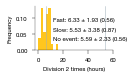

In [22]:
events = data.event_all_second_cell_count_increase_after_first_cell_count_increase_after_cell_type_conversion

hist_bins = np.linspace(0, 54, num=28, endpoint=True)
hist_tau = [tau - 1e-06 for (event_bool, tau) in events if event_bool]

beads_no_events = list()
beads_slow_events = list()
beads_fast_events = list()
for event_i, (event_bool, tau) in enumerate(events):
    if event_bool:
        if tau > 6:
            beads_slow_events.append(bead_numbers[event_i])
        else:
            beads_fast_events.append(bead_numbers[event_i])
    else:
        beads_no_events.append(bead_numbers[event_i])

print(len(beads_no_events))
print(len(beads_slow_events))
print(len(beads_fast_events))

print(fr'Average bead number +/- std (sem) (no event) = {round(np.mean(beads_no_events),2)} ± {round(np.std(beads_no_events),2)} ({round(stats.sem(beads_no_events, ddof=0),2)})')
print(fr'Average bead number +/- std (sem) (slow event) = {round(np.mean(beads_slow_events),2)} ± {round(np.std(beads_slow_events),2)} ({round(stats.sem(beads_slow_events, ddof=0),2)})')
print(fr'Average bead number +/- std (sem) (fast event) = {round(np.mean(beads_fast_events),2)} ± {round(np.std(beads_fast_events),2)} ({round(stats.sem(beads_fast_events, ddof=0),2)})')

plt.figure(figsize=(1.4, 0.8))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xlabel('Division 2 times (hours)')
plt.ylabel('Frequency')
plt.hist(hist_tau,
                bins=hist_bins,
                color=cwdiv,
                density=True,
                histtype='stepfilled', # step, stepfilled
                linewidth=2.0)

plt.axvline(x=6.0, linewidth=0.5, color=grey)
plt.axvline(x=54.0, linewidth=0.5, color=grey)

plt.text(12, 0.03, f'No event: {round(np.mean(beads_no_events),2)} ± {round(np.std(beads_no_events),2)} ({round(stats.sem(beads_no_events, ddof=0),2)})')
plt.text(12, 0.06, f'Slow: {round(np.mean(beads_slow_events),2)} ± {round(np.std(beads_slow_events),2)} ({round(stats.sem(beads_slow_events, ddof=0),2)})')
plt.text(12, 0.09, f'Fast: {round(np.mean(beads_fast_events),2)} ± {round(np.std(beads_fast_events),2)} ({round(stats.sem(beads_fast_events, ddof=0),2)})')

plt.xlim(None, 60)
# plt.legend()
plt.savefig('paper_figures/data_waiting_time_event_division2.pdf', bbox_inches='tight')

##### example well for describing events

30.0 12.0 10.0


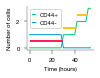

In [41]:
well_ind = 0
e_act = data.event_all_first_cell_type_conversion[well_ind][1]
e_div1 = data.event_all_first_cell_count_increase_after_cell_type_conversion[well_ind][1]
e_div2 = data.event_all_second_cell_count_increase_after_first_cell_count_increase_after_cell_type_conversion[well_ind][1]
print(e_act, e_div1, e_div2)

plt.figure(figsize=(1.2, 0.8))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xlabel('Time (hours)')
plt.ylabel('Number of cells')

plt.plot(data.data_time_values, data.data_counts[well_ind, 0, :], label='CD44+', lw=1, c=cactiv)
plt.plot(data.data_time_values, data.data_counts[well_ind, 1, :], label='CD44-', lw=1, c=cnaive)

ax.hlines(y=0.5, xmin=0, xmax=e_act, linewidth=2, color=cwact, zorder=100)
ax.hlines(y=1.5, xmin=e_act, xmax=e_act+e_div1, linewidth=2, color=cwdiv, zorder=100)
ax.hlines(y=2.5, xmin=e_act+e_div1, xmax=e_act+e_div1+e_div2, linewidth=2, color=cwdiv, zorder=100)

# plt.xlim(None, 60)
plt.legend()
plt.savefig(f'paper_figures/data_well_{well_ind+1}_index{well_ind}.pdf', bbox_inches='tight')

##### plot all 44 single well traces

In [46]:
print(data.data_counts.shape)
print(np.max(data.data_counts))

(44, 2, 28)
9.0


In [61]:
for well_ind in range(0, data.data_counts.shape[0]):
    plt.figure(figsize=(0.6, 0.4))
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    # plt.xlabel('Time (hours)')
    # plt.ylabel('Number of cells')

    plt.plot(data.data_time_values, data.data_counts[well_ind, 0, :], lw=1, c=cactiv) # , label='CD44+'
    plt.plot(data.data_time_values, data.data_counts[well_ind, 1, :], lw=1, c=cnaive) # , label='CD44-'

    # plt.xlim(None, 60)
    plt.ylim(-0.5, 9)
    plt.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)

    plt.text(6, 7, f'Well {well_ind+1}')

    # plt.legend()
    plt.savefig(f'paper_figures/single_well_traces/data_well_{well_ind+1}_index{well_ind}_tiny.pdf', bbox_inches='tight')
    plt.close()

##### analysis of boostrapped statistics
to do so, bootstrapping method of MemoCell were adapted below

In [64]:
data

mean

In [251]:
# input
count_data = data.data_counts
variable_ind = 1
time_value_ind = int(54/2) # 18, 36, 54
bootstrap_samples = 100000

# function
def bootstrapping_mean_stats(sample, num_resamples):
        ### ADAPTED FROM bootstrapping_mean method in Data
        
        ### sample should be a one-dimensional, flat array
        
        ### calculate the statistic of the sample
        stat_sample = np.mean(sample)

        ### bootstrap the standard error of the sample statistic (se_stat_sample)
        # draw random number from sample with replacement
        resamples = np.random.choice(sample, size=(num_resamples, *sample.shape), replace=True)

        # calculate the statistic for each resample
        stat_resamples = np.mean(resamples, axis=1)

        # compute the standard error as standard deviation over all statistic resamples
        se_stat_sample = np.std(stat_resamples, ddof=1)

        return (stat_sample, se_stat_sample, stat_resamples)

# run
stat_sample, se_stat_sample, stat_resamples = bootstrapping_mean_stats(count_data[:, variable_ind, time_value_ind], bootstrap_samples)

In [252]:
data.data_counts[:, variable_ind, time_value_ind]

array([0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 0.])

In [253]:
# look at boostrapping results
print(stat_sample, se_stat_sample)

0.22727272727272727 0.07112502603295938


In [254]:
# compare with data used for inference
mu, sigma = data.data_mean[:, variable_ind, time_value_ind]
print(mu, sigma)

0.22727272727272727 0.07082511863411368


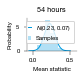

In [255]:
plt.rcParams.update({'figure.figsize': (0.9, 0.6)}) # 1.4, 0.97
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.hist(stat_resamples, density=True, color=cnaive if variable_ind else cactiv,
         label='Samples', histtype='stepfilled', alpha=0.3)
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 200)
plt.plot(x, stats.norm.pdf(x, mu, sigma), lw=1.0,
         label=f'$N({mu:.2f}, {sigma:.2f})$', c=cnaive if variable_ind else cactiv)
plt.title(f'{2*time_value_ind} hours')
plt.legend()
plt.ylabel('Probability')
plt.xlabel('Mean statistic')
plt.savefig(f'paper_figures/data_stats_mean_varind{variable_ind}_time{2*time_value_ind}.pdf', bbox_inches='tight')

variance

In [281]:
# input
count_data = data.data_counts
variable_ind = 1
time_value_ind = int(54/2) # 18, 36, 54
bootstrap_samples = 100000

# function
def bootstrapping_variance_stats(sample, num_resamples):
        ### ADAPTED FROM bootstrapping_variance method in Data
        
        ### sample should be a one-dimensional, flat array

        ### calculate the statistic of the sample
        stat_sample = np.var(sample, ddof=1)

        ### bootstrap the standard error of the sample statistic (se_stat_sample)
        # draw random number from sample with replacement
        resamples = np.random.choice(sample, size=(num_resamples, *sample.shape), replace=True)

        # calculate the statistic for each resample
        stat_resamples = np.var(resamples, axis=1, ddof=1)

        # compute the standard error as standard deviation over all statistic resamples
        se_stat_sample = np.std(stat_resamples, ddof=1)

        return (stat_sample, se_stat_sample, stat_resamples)

# run
stat_sample, se_stat_sample, stat_resamples = bootstrapping_variance_stats(count_data[:, variable_ind, time_value_ind], bootstrap_samples)

In [282]:
data.data_counts[:, variable_ind, time_value_ind]

array([0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 0.])

In [283]:
# look at boostrapping results
print(stat_sample, se_stat_sample)

0.22621564482029602 0.07464494271907612


In [284]:
# compare with data used for inference
mu, sigma = data.data_variance[:, variable_ind, time_value_ind]
print(mu, sigma)

0.22621564482029602 0.07472211608428457


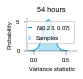

In [285]:
plt.rcParams.update({'figure.figsize': (0.9, 0.6)}) # 1.4, 0.97
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.hist(stat_resamples, density=True, color=cnaive if variable_ind else cactiv,
         label='Samples', histtype='stepfilled', alpha=0.3)
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 200)
plt.plot(x, stats.norm.pdf(x, mu, sigma), lw=1.0,
         label=f'$N({mu:.2f}, {sigma:.2f})$', c=cnaive if variable_ind else cactiv)
plt.title(f'{2*time_value_ind} hours')
plt.legend()
plt.ylabel('Probability')
plt.xlabel('Variance statistic')
plt.savefig(f'paper_figures/data_stats_variance_varind{variable_ind}_time{2*time_value_ind}.pdf', bbox_inches='tight')

covariance

In [295]:
# input
count_data = data.data_counts
time_value_ind = int(54/2) # 18, 36, 54
bootstrap_samples = 10000
count_indices = [0, 1]

# function
def bootstrapping_covariance_stats(sample1, sample2, num_resamples):
        ### ADAPTED FROM bootstrapping_covariance method in Data
        
        sample = np.array([sample1, sample2])

        ### calculate the statistic of the sample
        stat_sample = np.cov(sample[0, :], sample[1, :], ddof=1)[1,0]

        ### bootstrap the standard error of the sample statistic (se_stat_sample)
        # draw random number from sample with replacement
        resample_inds = [np.random.randint(sample.shape[1], size=sample.shape[1]) for i in range(num_resamples)]
        resamples = np.array([sample[:, ind] for ind in resample_inds])

        # calculate the statistic for each resample
        stat_resamples = np.zeros((num_resamples,))
        for resample_ind in range(num_resamples):
            stat_resamples[resample_ind] = np.cov(resamples[resample_ind, 0, :], resamples[resample_ind, 1, :], ddof=1)[0, 1]

        # compute the standard error as standard deviation over all statistic resamples
        se_stat_sample = np.std(stat_resamples, ddof=1)

        return (stat_sample, se_stat_sample, stat_resamples)

# run
stat_sample, se_stat_sample, stat_resamples = bootstrapping_covariance_stats(
                        count_data[:, count_indices[0], time_value_ind],
                        count_data[:, count_indices[1], time_value_ind],
                        bootstrap_samples)

In [296]:
# look at boostrapping results
print(stat_sample, se_stat_sample)

-0.7980972515856237 0.20210694145520908


In [297]:
# compare with data used for inference
mu, sigma = data.data_covariance[:, 0, time_value_ind]
print(mu, sigma)

-0.7980972515856235 0.2005798885800874


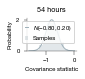

In [298]:
plt.rcParams.update({'figure.figsize': (0.9, 0.6)}) # 1.4, 0.97
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.hist(stat_resamples, density=True, color=grey,
         label='Samples', histtype='stepfilled', alpha=0.3)
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 200)
plt.plot(x, stats.norm.pdf(x, mu, sigma), lw=1.0,
         label=f'$N({mu:.2f}, {sigma:.2f})$', c=grey)
plt.title(f'{2*time_value_ind} hours')
plt.legend()
plt.ylabel('Probability')
plt.xlabel('Covariance statistic')
plt.savefig(f'paper_figures/data_stats_covariance_time{2*time_value_ind}.pdf', bbox_inches='tight')